In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import sys
from scipy.stats import multivariate_normal

# Add the parent directory of simpleparameterisation to the sys.path list
sys.path.append('../simpleparamaterisation/')

# Now you can import simpleparameterisation from the new location
import TPCevt as TPC

det = TPC.Detector("Simple TPC with Atmospheric Ar (default values)")


Welcome to JupyROOT 6.28/00


In [2]:
# Initial Parameter
pitch_x = 0.1
pitch_y = 0.1
std = det.PSFstd = 1
thresh = 1e-20
grid_size = 500
rv = multivariate_normal([0,0], np.diag([std, std]))


In [3]:
# Function Definition
def getDistribution(grid_size, offset):
    x, y = np.mgrid[-grid_size*pitch_x:(grid_size+1)*pitch_x:pitch_x,
            -grid_size*pitch_y:(grid_size+1)*pitch_y:pitch_y
            ]
    offset_x, offset_y = offset
    # pos = np.stack((x-offset_x, y-offset_y), axis =-1)
    gain = np.random.exponential(scale=det.gain_mean)
    top_right = np.stack((np.array([x+pitch_x/2-offset_x, y+pitch_y/2-offset_y])), axis=-1)
    bottom = np.stack((np.array([x+pitch_x/2-offset_x, y-pitch_y/2-offset_y])), axis=-1)
    left = np.stack((np.array([x-pitch_x/2-offset_x, y+pitch_y/2-offset_y])), axis=-1)
    bottom_left = np.stack((np.array([x-pitch_x/2-offset_x, y-pitch_y/2-offset_y])), axis=-1)

    # gain=1 #not considering gain effect for temporary

    val_cdf = (rv.cdf(top_right) - rv.cdf(bottom) - rv.cdf(left) + rv.cdf(bottom_left))*gain

    # plt.figure()
    # plt.title('Val CDF')
    # plt.scatter(x, y, c=val_cdf)
    # plt.xlim(-5, 5)
    # plt.ylim(-5, 5)
    # plt.colorbar()
    return x, y, val_cdf

def applyThreshold(x_1, y_1, readout_1, thresh):
    mask_1 = readout_1 >= thresh
    x_1_filtered = x_1[mask_1].flatten()
    y_1_filtered = y_1[mask_1].flatten()
    readout_1_filtered = readout_1[mask_1]
    return x_1_filtered, y_1_filtered, readout_1_filtered


def transformCoord(coord, dx, dy):
    print('initial: ', coord[0])
    coord[0] += dx
    coord[1] += dy
    
    return coord

def filterCoord(x, y, val, minvals, maxvals):
    filtered_x = []
    filtered_y = []
    filtered_val = []
    
    for x_val, y_val, v in zip(x, y, val):
        if minvals[0] <= x_val <= maxvals[0] and minvals[1] <= y_val <= maxvals[1]:
            filtered_x.append(x_val)
            filtered_y.append(y_val)
            filtered_val.append(v)
    return [filtered_x, filtered_y, filtered_val]

def getGridProps(coord, delta):
    index = int((coord + delta / 2) // delta)
    offset = coord - index*delta
    return index, offset

def count_decimal_places(number):
    if "." not in str(number):
        return 0
    return len(str(number).split(".")[1])

def ReadoutGain(DriftedEvt):
    DriftedEvtGrid = np.stack(DriftedEvt, axis=-1)
    minvals = np.array([DriftedEvtGrid[0].min(), DriftedEvtGrid[1].min()])
    maxvals = np.array([DriftedEvtGrid[0].max(), DriftedEvtGrid[1].max()])
    print(minvals, maxvals)
    CombinedEvt = {}
    comma_num_x = count_decimal_places(pitch_x)
    comma_num_y = count_decimal_places(pitch_y)
    # print(comma_num)


    def combineData(x, y, val):
        for i in range(len(x)):
            key = (np.around(x[i], comma_num_x), np.around(y[i], comma_num_y))
            if key in CombinedEvt:
                # print('initial', CombinedEvt[key])
                CombinedEvt[key] += val[i]
                # print('final', CombinedEvt[key])
            else:
                CombinedEvt[key] = val[i]
    
    for i in range(len(DriftedEvt)):
        coord = DriftedEvt[i]
        (index_x, offset_x) = getGridProps(coord[0], pitch_x)
        # print('index_x: ', index_x,', offset_x: ',  offset_x)

        (index_y, offset_y) = getGridProps(coord[1], pitch_y)
        # print('index_y: ', index_y,', offset_y: ',  offset_y)

        x_1, y_1, readout_1 = getDistribution(grid_size, [offset_x, offset_y])

        x_1_filtered, y_1_filtered, readout_1_filtered = applyThreshold(x_1, y_1, readout_1, thresh)
        
        x_1_filtered += index_x*pitch_x
        y_1_filtered += index_y*pitch_y
        
        # plt.figure()
        # plt.title('DriftedEvt item-')
        # plt.scatter(x_1_filtered, y_1_filtered, c=readout_1_filtered)
        # plt.colorbar()
        
        combineData(x_1_filtered, y_1_filtered, readout_1_filtered)
        x_comb, y_comb = zip(*CombinedEvt.keys())
        
    val_comb = list(CombinedEvt.values())

    filtered_coord = filterCoord(x_comb, y_comb, val_comb, minvals, maxvals)
    
    return filtered_coord

def plotReadout(ReadoutEvt):
    plt.figure()
    plt.title('Improved Readout Function')
    plt.axis('equal')
    plt.scatter(ReadoutEvt[0], ReadoutEvt[1], c = ReadoutEvt[2])
    plt.colorbar().set_label('Nel')


[1.929 2.11 ] [10.2   5.66]


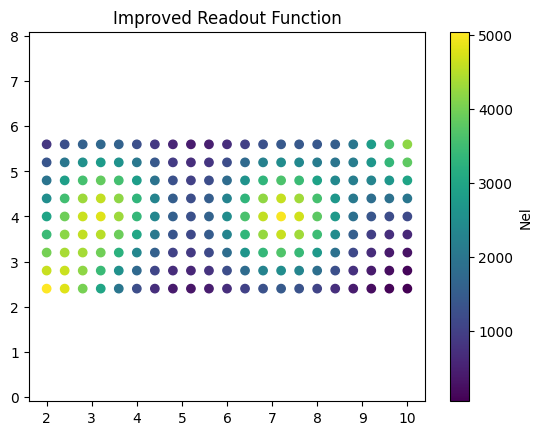

In [4]:
std = det.PSFstd = 1
pitch_x = 0.4
pitch_y = 0.4
thresh = 1e-5
grid_size = 100
rv = multivariate_normal([0,0], np.diag([std, std]))
N = 20


# Create the numpy array with the x and y values
DriftedEvt = np.array([[1.929,2.11], [3.21, 4.2], [10.2, 5.66], [7.22, 3.987]])

# print(DriftedEvt)
ReadoutEvt = ReadoutGain(DriftedEvt)
plotReadout(ReadoutEvt)

[1 0] [50 49]


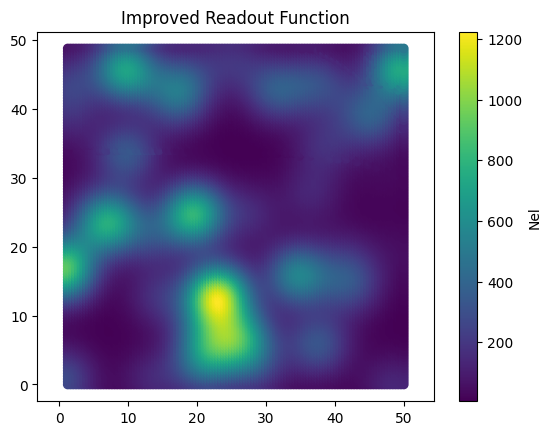

In [5]:
std = det.PSFstd = 10
pitch_x = 0.4
pitch_y = 0.4
thresh = 1e-50
grid_size = 100
rv = multivariate_normal([0,0], np.diag([std, std]))
N = 50


min_x, max_x = 0, 50
min_y, max_y = 0, 50
# Set a seed for reproducibility
np.random.seed(42)

# Generate random x and y values within the given range
x_values = np.random.randint(min_x, max_x + 1, size=N)
y_values = np.random.randint(min_y, max_y + 1, size=N)


# Create the numpy array with the x and y values
DriftedEvt = np.array([x_values, y_values]).T

# print(DriftedEvt)
ReadoutEvt = ReadoutGain(DriftedEvt)
plotReadout(ReadoutEvt)

[[18.72700594 48.47923139]
 [47.53571532 38.75664117]
 [36.59969709 46.97494708]
 [29.93292421 44.74136752]
 [ 7.80093202 29.89499894]
 [ 7.79972602 46.09371175]
 [ 2.90418061  4.4246251 ]
 [43.30880729  9.79914312]
 [30.05575059  2.26136445]
 [35.40362889 16.26651654]
 [ 1.02922471 19.43386448]
 [48.49549261 13.56745159]
 [41.62213204 41.43687546]
 [10.61695553 17.83766633]
 [ 9.09124836 14.04672548]
 [ 9.17022549 27.13480416]
 [15.21211215  7.04621125]
 [26.23782158 40.10984904]
 [21.59725093  3.72753218]
 [14.56145701 49.34434683]
 [30.59264474 38.61223846]
 [ 6.97469303  9.93578408]
 [14.60723243  0.27610586]
 [18.31809216 40.77307142]
 [22.80349921 35.34286719]
 [39.25879807 36.4503584 ]
 [ 9.98368911 38.56351733]
 [25.71172192  3.70223259]
 [29.62072844 17.92328643]
 [ 2.32252064  5.79345298]
 [30.3772426  43.15517129]
 [ 8.52620618 31.16490634]
 [ 3.25257965 16.54490124]
 [47.44427686  3.17791751]
 [48.28160165 15.54911609]
 [40.41986741 16.2591661 ]
 [15.23068846 36.48030892]
 

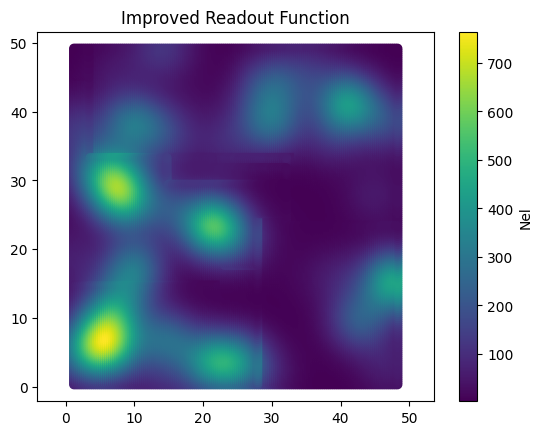

In [6]:
std = det.PSFstd = 10
pitch_x = 0.3
pitch_y = 0.3
thresh = 1e-50
grid_size = 50
rv = multivariate_normal([0,0], np.diag([std, std]))
N = 50

min_x, max_x = 0, 50
min_y, max_y = 0, 50
# Set a seed for reproducibility
np.random.seed(42)

# Generate random x and y values within the given range
x_values = np.random.rand(N) * (max_x - min_x) + min_x
y_values = np.random.rand(N) * (max_y - min_y) + min_y

# Create the numpy array with the x and y values
DriftedEvt = np.array([x_values, y_values]).T

print(DriftedEvt)
ReadoutEvt = ReadoutGain(DriftedEvt)
plotReadout(ReadoutEvt)